<a href="https://colab.research.google.com/github/sauravsb99/Pulmonary-Fibrosis/blob/main/Present.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 9.3MB/s 


In [ ]:
import copy
from datetime import timedelta, datetime
import imageio
import matplotlib.pyplot as plt
from matplotlib import cm
import multiprocessing
import numpy as np
import os
from pathlib import Path
import pydicom
import pytest
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import zoom
from skimage import measure, morphology, segmentation
from time import time, sleep
from tqdm import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import warnings

In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/PulmonaryFibrosis/archive.zip" -d "/content/osic-cached-dataset/"

Archive:  /content/drive/My Drive/PulmonaryFibrosis/archive.zip
  inflating: /content/osic-cached-dataset/ID00007637202177411956430.pt  
  inflating: /content/osic-cached-dataset/ID00009637202177434476278.pt  
  inflating: /content/osic-cached-dataset/ID00010637202177584971671.pt  
  inflating: /content/osic-cached-dataset/ID00011637202177653955184.pt  
  inflating: /content/osic-cached-dataset/ID00012637202177665765362.pt  
  inflating: /content/osic-cached-dataset/ID00014637202177757139317.pt  
  inflating: /content/osic-cached-dataset/ID00015637202177877247924.pt  
  inflating: /content/osic-cached-dataset/ID00019637202178323708467.pt  
  inflating: /content/osic-cached-dataset/ID00020637202178344345685.pt  
  inflating: /content/osic-cached-dataset/ID00023637202179104603099.pt  
  inflating: /content/osic-cached-dataset/ID00025637202179541264076.pt  
  inflating: /content/osic-cached-dataset/ID00026637202179561894768.pt  
  inflating: /content/osic-cached-dataset/ID0002763720217968

In [ ]:
!unzip "/content/drive/My Drive/PulmonaryFibrosis/PulmonaryFibrosis.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/ID00370637202296737666151/139.dcm  
  inflating: train/ID00370637202296737666151/14.dcm  
  inflating: train/ID00370637202296737666151/140.dcm  
  inflating: train/ID00370637202296737666151/141.dcm  
  inflating: train/ID00370637202296737666151/142.dcm  
  inflating: train/ID00370637202296737666151/143.dcm  
  inflating: train/ID00370637202296737666151/144.dcm  
  inflating: train/ID00370637202296737666151/145.dcm  
  inflating: train/ID00370637202296737666151/146.dcm  
  inflating: train/ID00370637202296737666151/147.dcm  
  inflating: train/ID00370637202296737666151/148.dcm  
  inflating: train/ID00370637202296737666151/149.dcm  
  inflating: train/ID00370637202296737666151/15.dcm  
  inflating: train/ID00370637202296737666151/150.dcm  
  inflating: train/ID00370637202296737666151/151.dcm  
  inflating: train/ID00370637202296737666151/152.dcm  
  inflating: train/ID00370637202296737666151/153.dcm  
  inflating: tra

In [ ]:
!ls


drive  sample_data  sample_submission.csv  test  test.csv  train  train.csv


In [ ]:
!cp -r "/content/drive/My Drive/PulmonaryFibrosis/test" "/content/"

In [ ]:
drive.flush_and_unmount()



In [ ]:
!rm sample_submission.csv





In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   49G   21G  71% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   24K  6.4G   1% /var/colab
/dev/sda1        75G   70G  4.9G  94% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            69G   50G   20G  72% /content/drive


In [ ]:
root_dir = '/content/osic-cached-dataset'
# train_dir = '/content/train'
test_dir = '/content/test'
model_file = '/content/working/model.pt'
resize_dims = (40, 256, 256)
clip_bounds = (-1000, 200)
watershed_iterations = 1
pre_calculated_mean = 0.02865046213070556
latent_features = 10
batch_size = 16
learning_rate = 3e-5
num_epochs = 100
val_size = 0.2


Preprocessing

## 3.1. ctscans_dataset.py
This interface ingests the data from the 3D CT scans, porting them to a PyTorch Dataset.**

In [ ]:
class CTScansDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.patients = [p for p in self.root_dir.glob('*') if p.is_dir()]
        self.transform = transform

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image, metadata = self.load_scan(self.patients[idx])
        sample = {'image': image, 'metadata': metadata}
        if self.transform:
            sample = self.transform(sample)

        return sample

    def save(self, path):
        t0 = time()
        Path(path).mkdir(exist_ok=True, parents=True)
        print('Saving pre-processed dataset to disk')
        sleep(1)
        cum = 0

        bar = trange(len(self))
        for i in bar:
            sample = self[i]
            image, data = sample['image'], sample['metadata']
            cum += torch.mean(image).item()

            bar.set_description(f'Saving CT scan {data.PatientID}')
            fname = Path(path) / f'{data.PatientID}.pt'
            torch.save(image, fname)

        sleep(1)
        bar.close()
        print(f'Done! Time {timedelta(seconds=time() - t0)}\n'
              f'Mean value: {cum / len(self)}')

    def get_patient(self, patient_id):
        patient_ids = [str(p.stem) for p in self.patients]
        return self.__getitem__(patient_ids.index(patient_id))

    @staticmethod
    def load_scan(path):
        slices = [pydicom.read_file(p) for p in path.glob('*.dcm')]
        try:
            slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        except AttributeError:
            warnings.warn(f'Patient {slices[0].PatientID} CT scan does not '
                          f'have "ImagePositionPatient". Assuming filenames '
                          f'in the right scan order.')

        image = np.stack([s.pixel_array.astype(float) for s in slices])
        return image, slices[0]

## 3.2. Pre-processing
There are some pre-processing to be done. Let's tackle them one step at a time.
### 3.2.1. crop_bounding_box.py

In [ ]:
class CropBoundingBox:
    @staticmethod
    def bounding_box(img3d: np.array):
        mid_img = img3d[int(img3d.shape[0] / 2)]
        same_first_row = (mid_img[0, :] == mid_img[0, 0]).all()
        same_first_col = (mid_img[:, 0] == mid_img[0, 0]).all()
        if same_first_col and same_first_row:
            return True
        else:
            return False

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        if not self.bounding_box(image):
            return sample

        mid_img = image[int(image.shape[0] / 2)]
        r_min, r_max = None, None
        c_min, c_max = None, None
        for row in range(mid_img.shape[0]):
            if not (mid_img[row, :] == mid_img[0, 0]).all() and r_min is None:
                r_min = row
            if (mid_img[row, :] == mid_img[0, 0]).all() and r_max is None \
                    and r_min is not None:
                r_max = row
                break

        for col in range(mid_img.shape[1]):
            if not (mid_img[:, col] == mid_img[0, 0]).all() and c_min is None:
                c_min = col
            if (mid_img[:, col] == mid_img[0, 0]).all() and c_max is None \
                    and c_min is not None:
                c_max = col
                break

        image = image[:, r_min:r_max, c_min:c_max]
        return {'image': image, 'metadata': data}

### 3.2.2. convert_to_hu.py


In [ ]:
class ConvertToHU:
    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']

        img_type = data.ImageType
        is_hu = img_type[0] == 'ORIGINAL' and not (img_type[2] == 'LOCALIZER')
        intercept = data.RescaleIntercept
        slope = data.RescaleSlope
        image = (image * slope + intercept).astype(np.int16)
        return {'image': image, 'metadata': data}

### 3.2.3. resize.py

In [ ]:
class Resize:
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        resize_factor = np.array(self.output_size) / np.array(image.shape)
        image = zoom(image, resize_factor, mode='nearest')
        return {'image': image, 'metadata': data}

### 3.2.4. clip.py

In [ ]:
class Clip:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        image[image < self.min] = self.min
        image[image > self.max] = self.max
        return {'image': image, 'metadata': data}

### 3.2.5. normalize.py, to_tensor.py, zero_center.py

In [ ]:
class Normalize:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        image = image.astype(np.float)
        image = (image - self.min) / (self.max - self.min)
        return {'image': image, 'metadata': data}
    

class ToTensor:
    def __init__(self, add_channel=True):
        self.add_channel = add_channel

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        if self.add_channel:
            image = np.expand_dims(image, axis=0)

        return {'image': torch.from_numpy(image), 'metadata': data}
    
    
class ZeroCenter:
    def __init__(self, pre_calculated_mean):
        self.pre_calculated_mean = pre_calculated_mean

    def __call__(self, tensor):
        return tensor - self.pre_calculated_mean

### 3.2.6. Inspecting some slices

In [ ]:
def show(list_imgs, cmap=cm.bone):
    list_slices = []
    for img3d in list_imgs:
        slc = int(img3d.shape[0] / 2)
        img = img3d[slc]
        list_slices.append(img)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 7))
    for i, img in enumerate(list_slices):
        axs[i].imshow(img, cmap=cmap)
        axs[i].axis('off')
        
    plt.show()

Masking CT scan ID00426637202313170790466: 100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


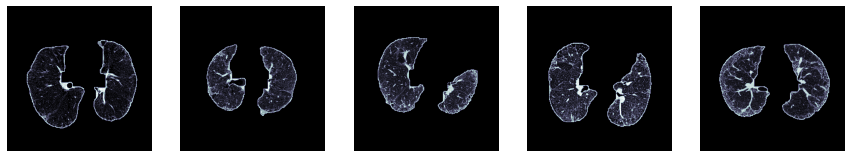

## 3.3. Caching pre-processed images in the disk



In [ ]:
dest_dir = root_dir
data = CTScansDataset(
    root_dir=train_dir,
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize(resize_dims),
        Clip(bounds=clip_bounds),
        MaskWatershed(
            min_hu=min(clip_bounds),
            iterations=watershed_iterations,
            show_tqdm=False),
        Normalize(bounds=clip_bounds),
        ToTensor()
    ]))
data.save(dest_dir)

Saving pre-processed dataset to disk



Saving CT scan ID00378637202298597306391:  19%|█▉        | 33/176 [07:57<43:05, 18.08s/it]

RuntimeError: ignored

In [ ]:
!rm -r osic-cached-dataset



In [ ]:
class CTTensorsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.tensor_files = sorted([f for f in self.root_dir.glob('*.pt')])
        self.transform = transform

    def __len__(self):
        return len(self.tensor_files)

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()

        image = torch.load(self.tensor_files[item])
        if self.transform:
            image = self.transform(image)

        return {
            'patient_id': self.tensor_files[item].stem,
            'image': image
        }

    def mean(self):
        cum = 0
        for i in range(len(self)):
            sample = self[i]['image']
            cum += torch.mean(sample).item()

        return cum / len(self)

    def random_split(self, val_size: float):
        num_val = int(val_size * len(self))
        num_train = len(self) - num_val
        return random_split(self, [num_train, num_val])

# 4. AutoEncoder


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_features=latent_features):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(1, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.conv4 = nn.Conv3d(96, 1, 1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.fc1 = nn.Linear(10 * 10, latent_features)
        # Decoder
        self.fc2 = nn.Linear(latent_features, 10 * 10)
        self.deconv0 = nn.ConvTranspose3d(1, 96, 1)
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 1, 3)
        self.unpool0 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, i1 = self.pool1(x)

        x = self.conv2(x)
        up2out_shape = x.shape
        x, i2 = self.pool2(x)

        x = self.conv3(x)
        up1out_shape = x.shape
        x, i3 = self.pool3(x)

        x = self.conv4(x)
        up0out_shape = x.shape
        x, i4 = self.pool4(x)

        x = x.view(-1, 10 * 10)
        x = F.relu(self.fc1(x))

        if return_partials:
            return x, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3, \
                   up0out_shape, i4

        else:
            return x

    def forward(self, x):
        x, up3out_shape, i1, up2out_shape, i2, \
        up1out_shape, i3, up0out_shape, i4 = self.encode(x)

        # Decoder
        x = F.relu(self.fc2(x))
        x = x.view(-1, 1, 1, 10, 10)
        x = self.unpool0(x, output_size=up0out_shape, indices=i4)
        x = self.deconv0(x)
        x = self.unpool1(x, output_size=up1out_shape, indices=i3)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=up2out_shape, indices=i2)
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=up3out_shape, indices=i1)
        x = self.deconv3(x)

        return x

## 5 Training 


In [ ]:
t0 = time()

# Load the data
data = CTTensorsDataset(
    root_dir=root_dir,
    transform=ZeroCenter(pre_calculated_mean=pre_calculated_mean)
)
train_set, val_set = data.random_split(val_size)
datasets = {'train': train_set, 'val': val_set}
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=batch_size,
        shuffle=(x == 'train'),
        num_workers=2
    ) for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

# Prepare for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(latent_features=latent_features).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_model_wts = None
best_loss = np.inf

date_time = datetime.now().strftime("%Y%m%d-%H%M")
log_dir = Path(tensorboard_dir) / f'{date_time}'
writer = SummaryWriter(log_dir)

In [ ]:
# Training loop
for epoch in range(num_epochs):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_preds = 0

        # Iterate over data.
        bar = tqdm(dataloaders[phase])
        for inputs in bar:
            bar.set_description(f'Epoch {epoch + 1} {phase}'.ljust(20))
            inputs = inputs['image'].to(device, dtype=torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, inputs)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_preds += inputs.size(0)
            bar.set_postfix(loss=f'{running_loss / running_preds:0.6f}')

        epoch_loss = running_loss / dataset_sizes[phase]
        writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model_file)

# load best model weights
model.load_state_dict(best_model_wts)

print(f'Done! Time {timedelta(seconds=time() - t0)}')

Epoch 100 val       : 100%|██████████| 3/3 [00:01<00:00,  1.64it/s, loss=0.015305]

Done! Time 1:04:14.304645


# 6. Testing


Inspecting CT Scan ID00186637202242472088675


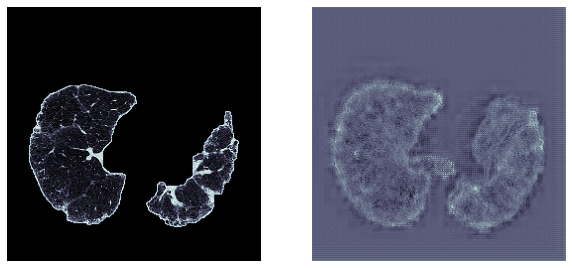

Latent features: [10.009194374084473, 8.650956153869629, 0.0, 0.0, 4.082302570343018, 0.0, 0.0, 9.275486946105957, 12.369450569152832, 8.289910316467285] 
Loss: 0.018677210165056964


In [ ]:
slc = 0.5
sample_id = np.random.randint(len(data))
print(f'Inspecting CT Scan {data[sample_id]["patient_id"]}')

fig, axs = plt.subplots(1, 2, figsize=(10, 7))

sample = data[sample_id]['image'].squeeze(0).numpy()
axs[0].imshow(sample[int(40 * slc), :, :], cmap=cm.bone)
axs[0].axis('off')
imageio.mimsave("sample_input.gif", sample, duration=0.0001)

with torch.no_grad():
    img = data[sample_id]['image'].unsqueeze(0).float().to(device)
    latent_features = model.encode(img, return_partials=False)\
        .squeeze().cpu().numpy().tolist()
    outputs = model(img).squeeze().cpu().numpy()

axs[1].imshow(outputs[int(40 * slc), :, :], cmap=cm.bone)
axs[1].axis('off')

imageio.mimsave("sample_output.gif", outputs, duration=0.0001)

rmse = ((sample - outputs)**2).mean()
plt.show()
print(f'Latent features: {latent_features} \nLoss: {rmse}')